# Conditional IC generation

In [1]:
import cosmax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax

In [2]:
# load image with matplotlib
img = plt.imread('../data/cosmax.png')
img = jnp.array(img)[..., 0:1]
img = jnp.moveaxis(img, 2, 0)

print(img.shape)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(1, 64, 64)


In [10]:
N = 64
MPC_h = 50

img = jnp.broadcast_to(img, (N, N, N))

img = img - jnp.mean(img)


power_spectrum = cosmax.spectral_ops.PowerSpectrum(N, N, MPC_h)

# Lets generate a power spectrum from a power law
Pk_desired = power_spectrum.k**(-3)

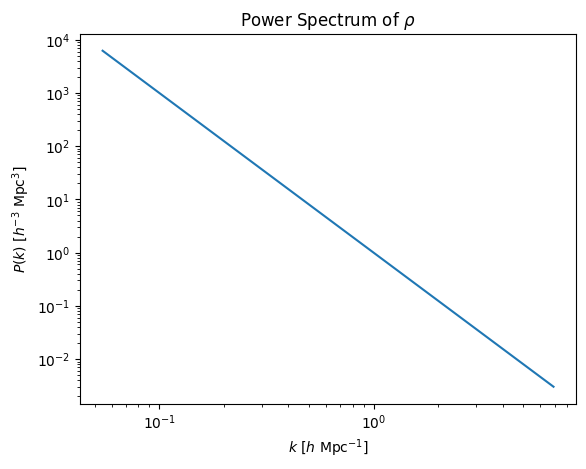

In [11]:
plt.plot(power_spectrum.k, Pk_desired, label='cosmax')
plt.title(r'Power Spectrum of $\rho$')
plt.xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
plt.ylabel(r'$P(k)$ [$h^{-3} \ \mathrm{Mpc}^3$]')
plt.xscale('log')
plt.yscale('log')

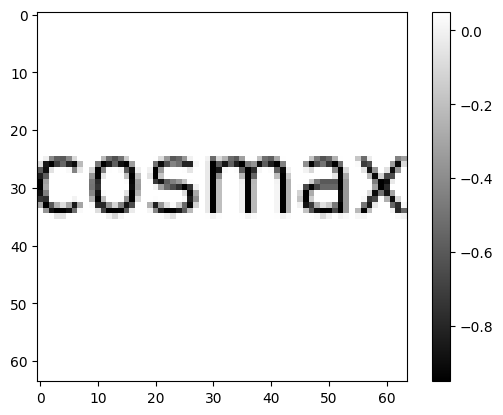

In [12]:
plt.figure()

plt.imshow(img[N // 2], cmap='gray')
plt.colorbar()

In [13]:
generator = cosmax.spectral_ops.Generator(N, MPC_h)

In [25]:
def mse(x, y):
    return jnp.mean((x - y)**2)

def loss(
    field : jax.Array) -> jax.Array:

    # Compute the power spectrum of the field
    field = generator(field, Pk_desired)
    k, Pk = power_spectrum(field)

    loss_ps = mse(jnp.log(Pk), jnp.log(Pk_desired))

    loss_img = mse(field, img)

    return 0.3*loss_ps + loss_img


In [28]:
import optax

opt = optax.adam(0.003)

field = jax.random.normal(jax.random.PRNGKey(0), (N, N, N))

opt_state = opt.init(field)

@jax.jit
def step(
    field : jax.Array,
    opt_state : optax.OptState) -> jax.Array:

    grad = jax.grad(loss)(field)

    updates, opt_state = opt.update(grad, opt_state)

    field = optax.apply_updates(field, updates)

    return field, opt_state

for i in range(9000):
    field, opt_state = step(field, opt_state)

    if i % 100 == 0:
        print(loss(field))

0.36964372
0.21338335
0.19766705
0.18909825
0.18168925
0.17559238
0.17071413
0.16671675
0.16335978
0.16049784
0.15803002
0.1558753
0.15396608
0.15224743
0.15067676
0.14922152
0.14785548
0.14655766
0.14531069
0.14409973
0.14291175
0.14173652
0.14056508
0.13939077
0.13820787
0.13701269
0.13580225
0.13457489
0.13333026
0.13206886
0.13079175
0.12950064
0.12819847
0.12688774
0.12557176
0.1242541
0.122937664
0.12162607
0.120322004
0.11902815
0.11774684
0.11647977
0.11522827
0.11399363
0.11277613
0.111576185
0.11039376
0.10922855
0.10807997
0.107032314
0.105929054
0.105347164
0.1045291
0.10311288
0.102260455
0.10162832
0.1015297
0.10013047
0.09922743
0.09862225
0.09890405
0.097270414
0.09668353
0.096102625
0.096329734
0.09540235
0.09450841
0.09396933
0.094052374
0.09368772
0.092584856
0.09209078
0.09181331
0.091788806
0.090935856
0.09046389
0.090359986
0.09032683
0.0893884
0.08896205
0.08874984
0.0890615
0.08830624
0.08764083
0.088424705
0.08811408
0.0869848
0.086470574
0.086202316
0.08652717

Text(0.5, 1.0, '$\\rho$')

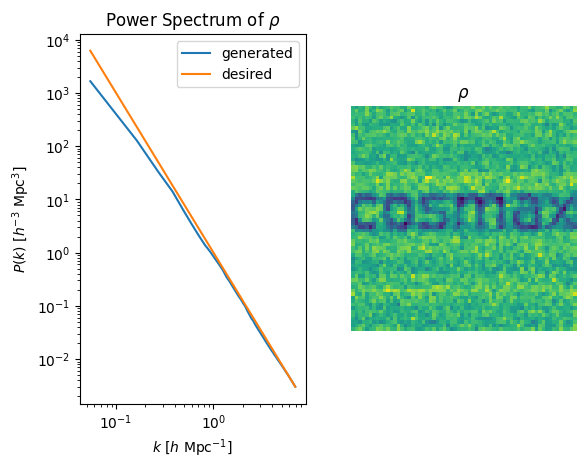

In [29]:
# rho = cosmax.tools.compute_overdensity(field)
field = generator(field, Pk_desired)
k_gen, Pk_gen = power_spectrum(field)

axs, fig = plt.subplots(1, 2)

fig[0].plot(k_gen, Pk_gen, label='generated')
fig[0].plot(k_gen, Pk_desired, label='desired')
fig[0].set_title(r'Power Spectrum of $\rho$')
fig[0].set_xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
fig[0].set_ylabel(r'$P(k)$ [$h^{-3} \ \mathrm{Mpc}^3$]')
fig[0].set_xscale('log')
fig[0].set_yscale('log')
fig[0].legend()

fig[1].imshow(field[N//2])
# remove axis
fig[1].axis('off')
fig[1].set_title(r'$\rho$')

